In [11]:
%matplotlib inline
import os, shutil, warnings, string
import pandas as pd
import deepdish as dp
import numpy as np
import re
import fnmatch

# libs for plotting
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models.tools import HoverTool
from bokeh.models import LinearColorMapper, ColorBar, BasicTicker, Select, PrintfTickFormatter
from bokeh.transform import jitter
from bokeh.sampledata.commits import data
from bokeh.palettes import brewer
import holoviews

# libs for stats
import time
from sklearn.manifold import TSNE

# print in notebok
output_notebook()

Loading BokehJS ...

In [12]:
datapath = '/Volumes/extreme/repos/lab-data/characterization/autoscan/'
datapath_processed = 'processed'
datapath_raw       = 'raw'
datapath_generic   = '_generic*'
datapath_fluids    = '_fluids'
datapath_analysis  = '_analysis'
datapath_exclude   = ['special-studies',datapath_raw,datapath_generic,datapath_analysis,'*layout*']
files_exclude      = ['.*','_*','*.asd','*.tcl']
files_include      = ['*.csv']

## List and correct filenames (enforce patterns)

1. Read the _csv_ files in the `datapath`
1. Find whether each file has the word `before` or `after`
1. If not, then add `before` as default
1. Fix all file names such that they follow `probe-before|after-side.csv` 

In [13]:
def _rename_file(root,fname_old, fname_new):
    oldname = os.path.join(root,fname_old)
    newname = os.path.join(root,fname_new)
    shutil.move(oldname,newname)
    return

def add_before_fname(fname,root,dryrun=False, debug=False):
    name2 = re.sub(r'(perm|vel|impulse|ftir).*([a-z]+)[.]([a-z]+)',r'\1-before-\2.\3',fname)
    if debug: print(fname, name2, sep='\t')
    if not dryrun:
        _rename_file(root, fname, name2)
    return name2

def swap_instance_fname(fname,root,dryrun=False, debug=False):
    name2 = re.sub(r'(perm|vel|impulse|ftir)-([a-z]+|[0-9]+)-.*(before|after).*[.]([a-z]+)',r'\1-\3-\2.\4',
                   fname)
    if debug: print(fname,name2,sep='\t')
    if not dryrun:
        _rename_file(root, fname, name2)
    return name2
def check_autoscan_fname(fname, root, dryrun=False, debug=False):
    instance = None
    if (not 'before' in fname) and (not 'after' in fname):
        warnings.warn('before or after not found in ' + fname)
        fname = add_before_fname(fname, root, dryrun=dryrun, debug=debug)

    instance = re.findall('before|after',fname)
    if len(instance)==1:
        instance = instance[0]
        # if debug: print(instance, fname, sep='\t')
        if len(fname.split('-'))>2:
            tst = re.match(r'(perm|vel|impulse|ftir)-(before|after).*([a-z]+)[.]([a-z]+)', fname)
            if tst is None:
                fname = swap_instance_fname(fname, root, dryrun=dryrun, debug=debug)
    else:
        if len(instance)>1:
            warning = fname + ' has more than one instance: ' + ', '.join(instance)
            warning = warning + ' and cannot choose! \n check ' + os.path.join(root,fname) 
        if len(instance)==0:
            warning = fname + ' not in either category (!) \n please review!'
        warnings.warn(warning)
    return instance, fname

In [22]:
dryrun = True
debug  = True

excludes = r'|'.join([fnmatch.translate(x) for x in files_exclude]) or r'$.'
includes = r'|'.join([fnmatch.translate(x) for x in files_include]) or r'$.'

df = pd.DataFrame(columns=['probe','sample-tag','subsample-tag','side','instance','fname','relroot'])

for root, dirs, files in os.walk(datapath):
    [dirs.remove(d) for d in list(dirs) if d in datapath_exclude]
    files = [f for f in files if not re.match(excludes, f)]
    files = [f for f in files if re.match(includes, f)]
    for fname in files:
        # if debug: print(root, fname)
        instance,fname = check_autoscan_fname(fname, root, dryrun=dryrun, debug=debug)
        # determine sample name
        sample_tag = root.split('/')[len(datapath.split('/'))-1]
        # determine if the file is subsample or sample
        subornot = re.findall('subsample',root)
        if len(subornot)==1:
            subornot = subornot[0]
            subsample_tag = root.split('/')[-2]
        else:
            subsample_tag = ''
        side = ''
        if len(fname.split('-'))>2:
            side = fname.split('-')[-1].lower().replace('.csv','')

        df = df.append({
            'probe':re.findall(r'perm|vel|impulse|ftir',fname)[0],
            'sample-tag':sample_tag,
            'subsample-tag':subsample_tag,
            'side':side,
            'instance':instance,
            'fname':fname,
            'relroot':os.path.relpath(os.path.join(root,fname),start=datapath)
        }, ignore_index=True)
df.sort_values(by=['sample-tag','subsample-tag','probe','side'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [23]:
for tag in df['sample-tag'].unique():
    df_tag = df.loc[df['sample-tag']==tag,:].copy()
    for subtag in df_tag['subsample-tag'].unique():
        print(tag,subtag, sep='\t')

BG-00003	
BG-00003	slab-A
BG-00004	
BG-00004	S1-1
BG-00004	S1-2
BG-00004	line-01
BG-00006	
BG-00007	
BG-00008	
BG-00009	
Lssy-00010	
Lssy-00014	
Lssy-00015	
Lssy-00016	
Mb-00001	
SH-00001	
SH-00006	
SH-00007	
SH-00008	


In [37]:
dt = df.loc[(df['sample-tag']=='BG-00003') & (df['probe']=='perm'),:].copy()

In [38]:
dfs = []
for relroot in dt['relroot']:
    fpath = os.path.join(datapath,relroot)
    dperm = pd.read_csv(fpath, skiprows=7, usecols=[0,1,2,12], names = ['x','y','permeability','tile'])
    dperm = dperm.apply(pd.to_numeric,errors='coerce').dropna()
    for key in ['subsample-tag','side','instance']:
        dperm[key] = dt.loc[dt['relroot']==relroot,key].values[0]
    dfs.append(dperm)
dperm = pd.concat(dfs)

In [39]:
np.average(dperm.loc[dperm['instance']=='before','permeability'].values)#.apply(np.average)

115.52694248511905

In [40]:
np.average(dperm.loc[dperm['instance']=='after','permeability'].values)

337.2539

In [55]:
dfb = dperm.loc[dperm['instance']=='before', :].copy()
for side in dfb['side'].unique():
    dfb.loc[dfb['side']==side,['x','y','permeability']].to_csv(
        os.path.join(datapath, 'BG-00003','_analysis','before-' + side + '.csv'), index=False)

In [56]:
dfb = dperm.loc[dperm['instance']=='after', :].copy()
for side in dfb['side'].unique():
    dfb.loc[dfb['side']==side,['x','y','permeability']].to_csv(
        os.path.join(datapath, 'BG-00003','_analysis','after' + side + '.csv'), index=False)

In [50]:
dfb = dperm.loc[dperm['instance']=='before', :].copy()
cmax = dfb.loc[dfb['side']=='b', 'x'].max(axis=0)

In [30]:
dfb = dperm.loc[dperm['instance']=='before', :].copy()
dfb.loc[dfb['side']=='a', 'z'] = dfb.loc[dfb['side']=='d', 'x'].max(axis=0)
dfb.loc[dfb['side']=='c', 'z'] = 0.
dfb.loc[dfb['side']=='b', 'z'] = dfb.loc[dfb['side']=='b', 'x'].values
dfb.loc[dfb['side']=='b', 'x'] = dfb.loc[dfb['side']=='d', 'x'].max(axis=0)
dfb.loc[dfb['side']=='d', 'z'] = dfb.loc[dfb['side']=='d', 'x'].values
dfb.loc[dfb['side']=='d', 'x'] = 0.
dfb = dfb.loc[:,['x','y','z','permeability']].copy()
dfb.to_csv(os.path.join(datapath, 'BG-00003','_analysis','before.csv'))

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

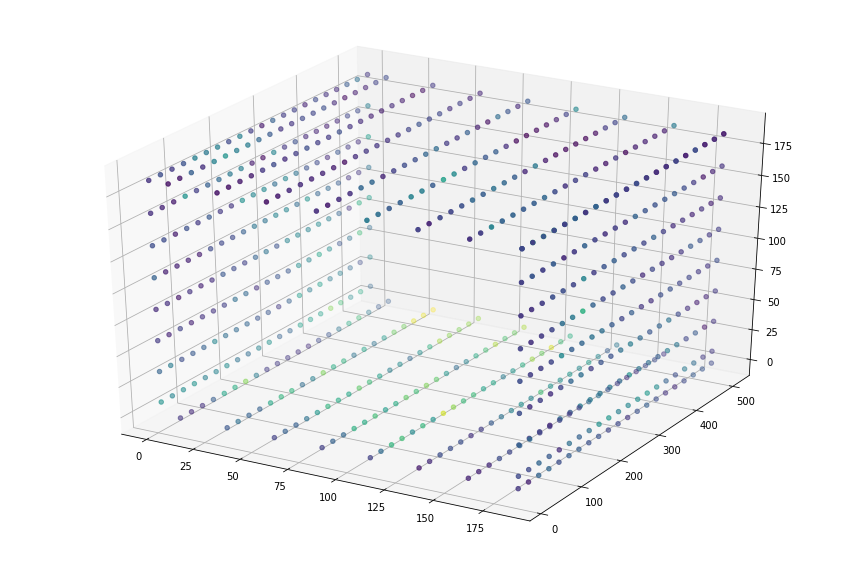

In [32]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfb.x.values, dfb.y.values, dfb.z.values, c=dfb.permeability.values)

In [33]:
dfa = dperm.loc[dperm['instance']=='after', :].copy()
dfa['z'] = dfb.loc[:, 'z'].max(axis=0)/2.
dfa = dfa.loc[:,['x','y','z','permeability']].copy()
dfa.to_csv(os.path.join(datapath, 'BG-00003','_analysis','after.csv'))

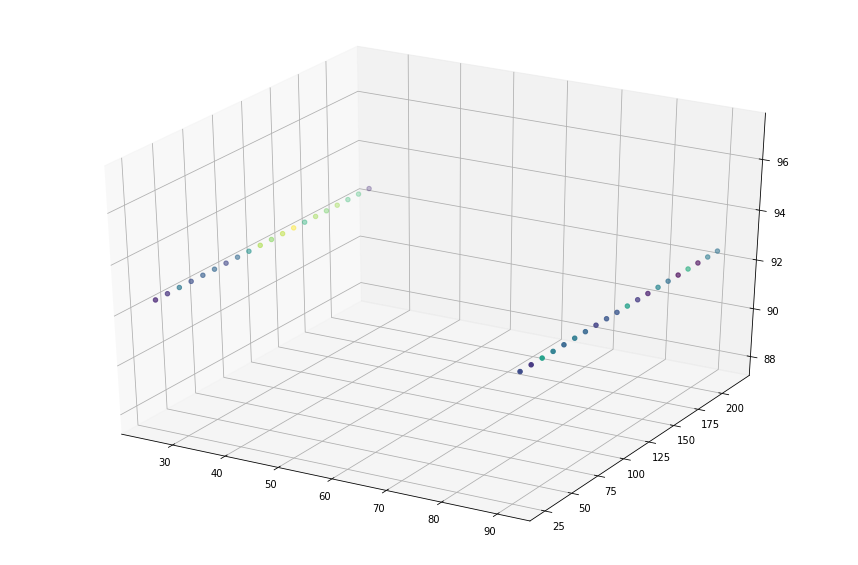

In [34]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfa.x.values, dfa.y.values, dfa.z.values, c=dfa.permeability.values)

In [35]:
dfc = pd.concat([dfa,dfb], ignore_index=True)
dfa.to_csv(os.path.join(datapath, 'BG-00003','_analysis','before-and-after.csv'))

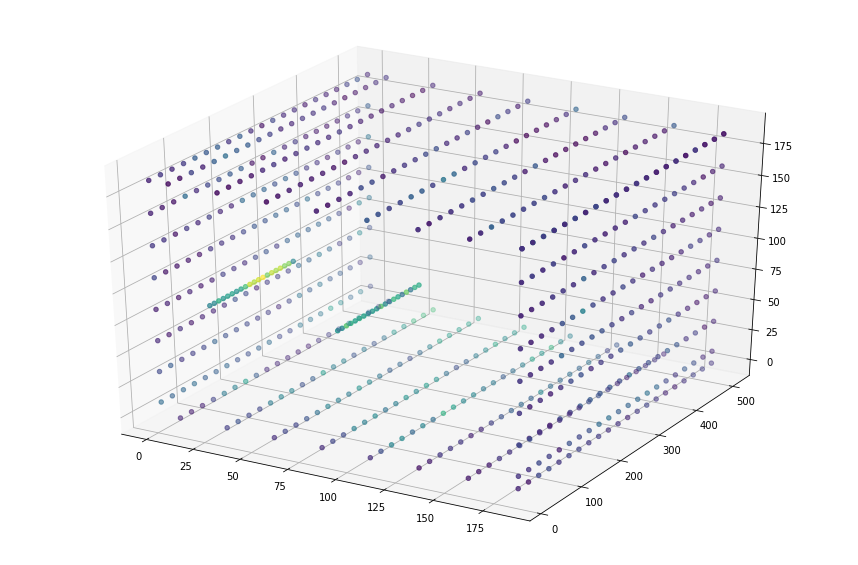

In [36]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfc.x.values, dfc.y.values, dfc.z.values, c=dfc.permeability.values)

In [114]:
dfa.permeability.max(axis=0)

524.438

In [115]:
dfb.permeability.max(axis=0)

362.02099999999996

In [52]:
dfb.to_csv?